# Lesson 3. Image Segmentation with Camvid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

### Download Data

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

### Data Exploration

In [5]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/jupyter/.fastai/data/camvid/images/Seq05VD_f00720.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_07961.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_08153.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0001TP_007650.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_08015.png')]

In [6]:
label_names = get_image_files(path_lbl)
label_names[:5]

[PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_06600_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0006R0_f01050_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/Seq05VD_f04290_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0001TP_009180_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_06180_P.png')]

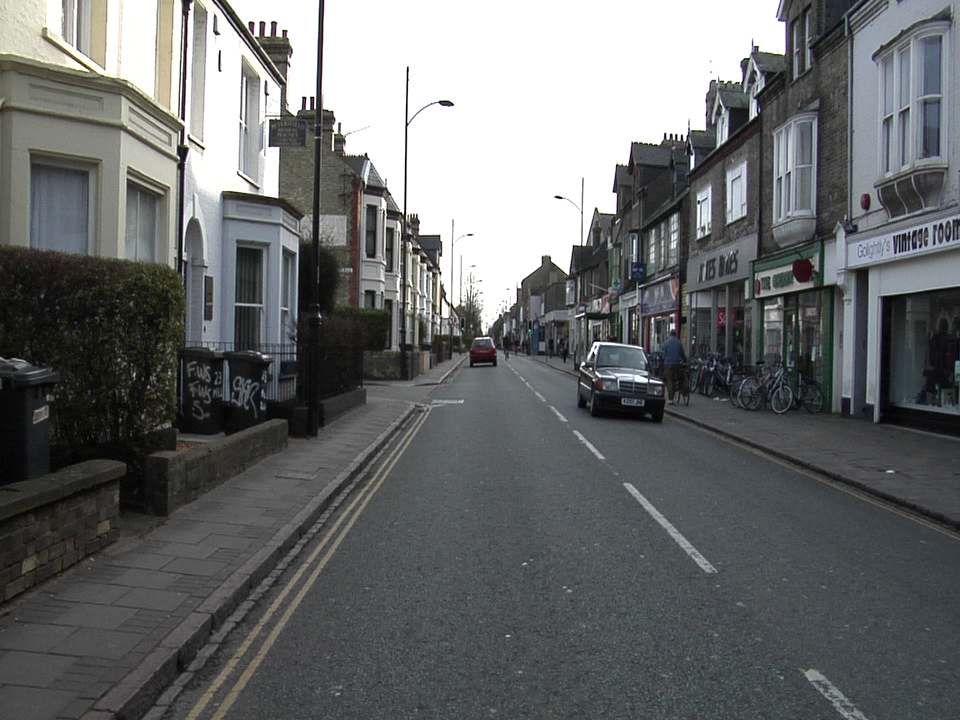

In [14]:
img_f = fnames[0]
img = open_image(img_f)
img

In [16]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

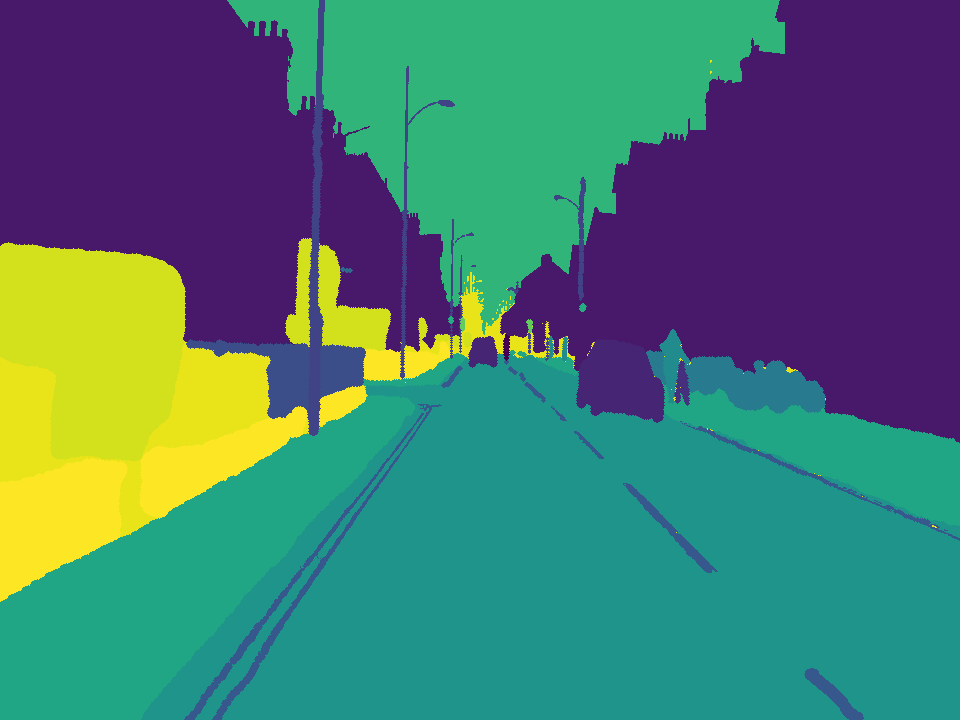

In [20]:
mask = open_mask(get_y_fn(img_f))
mask

In [21]:
src_size = np.array(mask.shape[1:])

In [22]:
src_size

array([720, 960])

In [24]:
mask.data #open_mask automatically color code integer below 

tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
         [ 4,  4,  4,  ...,  4,  4,  4],
         [ 4,  4,  4,  ...,  4,  4,  4],
         ...,
         [19, 19, 19,  ..., 17, 17, 17],
         [19, 19, 19,  ..., 17, 17, 17],
         [19, 19, 19,  ..., 17, 17, 17]]])

In [28]:
codes = np.loadtxt(path/'codes.txt', dtype=str); print(codes)

['Animal' 'Archway' 'Bicyclist' 'Bridge' 'Building' 'Car' 'CartLuggagePram' 'Child' 'Column_Pole' 'Fence'
 'LaneMkgsDriv' 'LaneMkgsNonDriv' 'Misc_Text' 'MotorcycleScooter' 'OtherMoving' 'ParkingBlock' 'Pedestrian' 'Road'
 'RoadShoulder' 'Sidewalk' 'SignSymbol' 'Sky' 'SUVPickupTruck' 'TrafficCone' 'TrafficLight' 'Train' 'Tree' 'Truck_Bus'
 'Tunnel' 'VegetationMisc' 'Void' 'Wall']


### Datasets

In [29]:
size = src_size//2

free = gpu_mem_get_free_no_cache() # the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11430MB of GPU RAM free


In [48]:
src = (SegmentationItemList.from_folder(path_img) 
      .split_by_fname_file('../valid.txt') 
      .label_from_func(get_y_fn, classes = codes))

In [49]:
data = (src.transform(get_transforms(), size = size, tfm_y = True) #transform y as well as x do, if x flips, then flip y too.
       .databunch(bs=bs)
       .normalize(imagenet_stats))

In [50]:
data

ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/jupyter/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/jupyter/.fastai/data/camvid/images;

Test: None

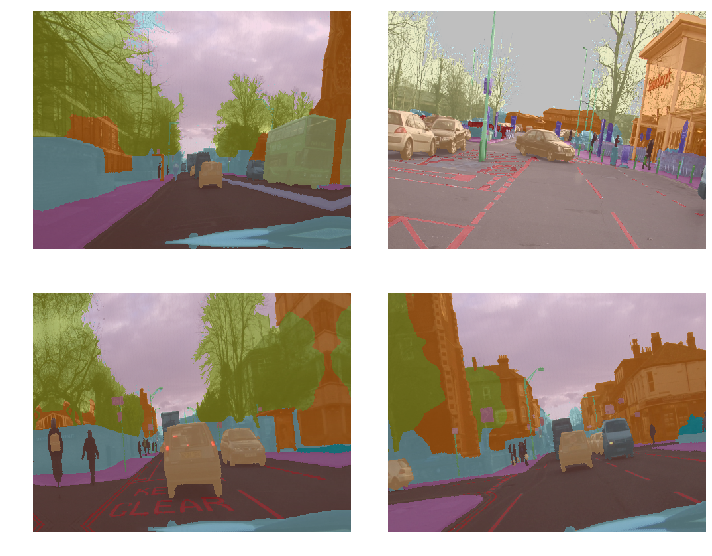

In [46]:
data.show_batch(rows=2, figsize=(10,8))

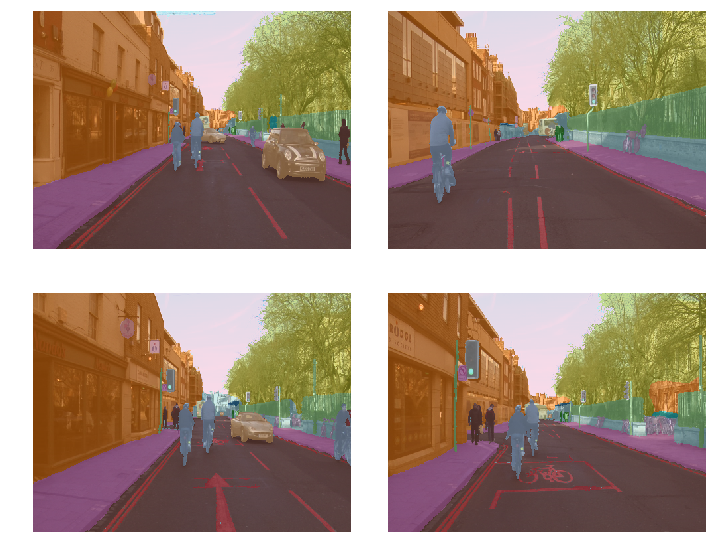

In [41]:
data.show_batch(rows=2, figsize=(10,8), ds_type=DatasetType.Valid)

### Model

In [51]:
name2id = {v:k for k,v in enumerate(codes)} ; name2id

{'Animal': 0,
 'Archway': 1,
 'Bicyclist': 2,
 'Bridge': 3,
 'Building': 4,
 'Car': 5,
 'CartLuggagePram': 6,
 'Child': 7,
 'Column_Pole': 8,
 'Fence': 9,
 'LaneMkgsDriv': 10,
 'LaneMkgsNonDriv': 11,
 'Misc_Text': 12,
 'MotorcycleScooter': 13,
 'OtherMoving': 14,
 'ParkingBlock': 15,
 'Pedestrian': 16,
 'Road': 17,
 'RoadShoulder': 18,
 'Sidewalk': 19,
 'SignSymbol': 20,
 'Sky': 21,
 'SUVPickupTruck': 22,
 'TrafficCone': 23,
 'TrafficLight': 24,
 'Train': 25,
 'Tree': 26,
 'Truck_Bus': 27,
 'Tunnel': 28,
 'VegetationMisc': 29,
 'Void': 30,
 'Wall': 31}

In [52]:
void_code = name2id['Void'] # have to remove the void code 

In [53]:
def acc_camvid(input, target): # accuracy metrics 
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [54]:
metrics = acc_camvid

In [58]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd= 1e-2)

In [60]:
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,acc_camvid,time
0,1.490308,1.068789,0.706869,03:44


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


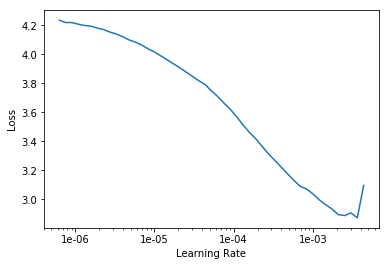

In [ ]:
learn.fit_one_cycle(1)

In [61]:
lr=3e-3

In [62]:
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.946407,0.764377,0.824966,03:45
1,0.814962,0.665892,0.838479,03:46
2,0.747351,0.530850,0.862333,03:43
3,0.653741,0.529978,0.870832,03:42
4,0.582759,0.424346,0.885687,03:41


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


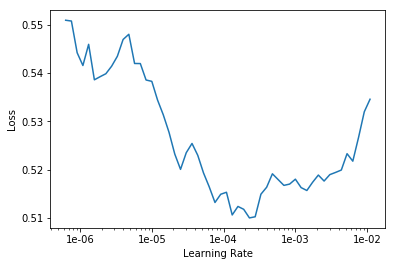

In [64]:
lr_find(learn)
learn.recorder.plot()

In [65]:
learn.save('stage-1')

In [66]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/jupyter/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/jupyter/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

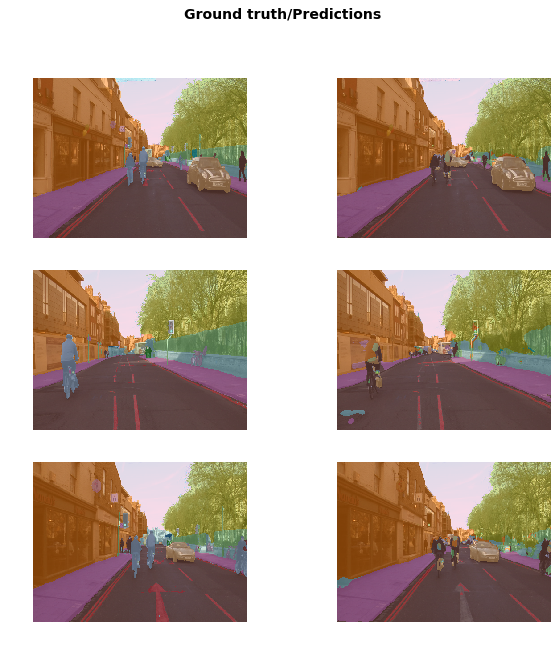

In [68]:
learn.show_results(rows=3, figsize=(10, 10))

In [69]:
learn.unfreeze()

In [70]:
lr = 1e-4
lrs = slice(lr/400,lr/4)

In [71]:
lrs

slice(2.5e-07, 2.5e-05, None)

In [72]:
learn.fit_one_cycle(4, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.520266,0.423839,0.885846,03:52
1,0.509897,0.422359,0.885418,03:49
2,0.497553,0.417503,0.886472,03:53
3,0.487461,0.414260,0.888334,03:50


In [73]:
learn.save('stage-2')

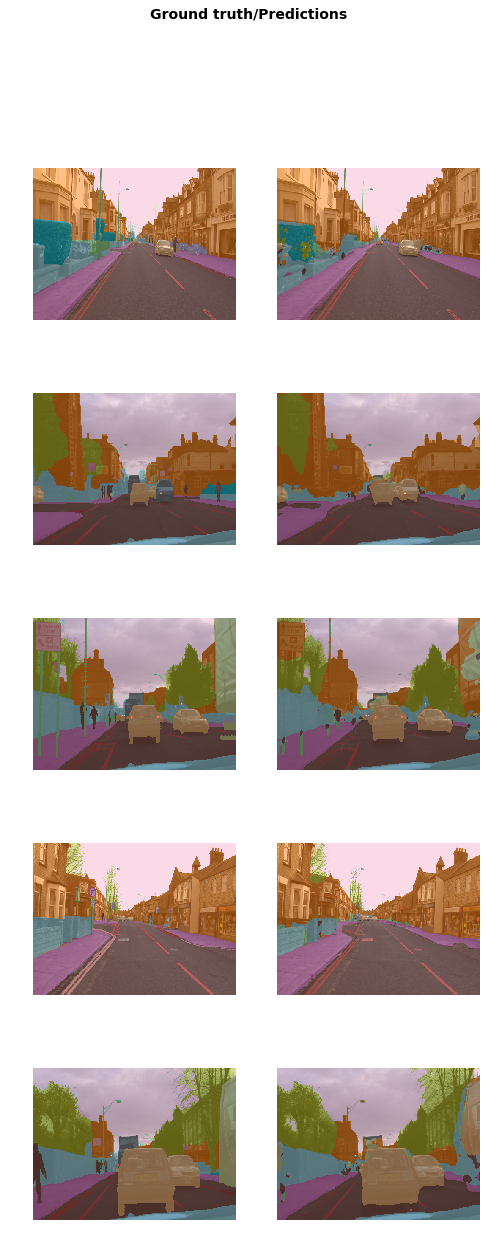

In [76]:
learn.show_results(3)